In [1]:
import numpy as np
import matplotlib.pylab as plt
import math

# Grid interpolations
Defines grid classes and interpolation of a fine grid from a coarse grid.

In [2]:
class grid:
    """
    Contains information on a grid at a fixed refinement level.
    latticeSites=[ nSites , ...   ] number of sites per dimensions
    box : real space positions of the vertices
    nGhosts : [ n , ...] number of ghost cells for each dimensions
    """
    def __init__(self,nSites,nGhosts=None,box=None):
        self.nSites=nSites
        self.dimensions=len(self.nSites)
        if box is None:
            box=[[-1,1] for d in range(self.dimensions)]
        self.box=box
        if nGhosts is None:
            nGhosts=[0 for d in range(self.dimensions)]
        self.nGhosts=nGhosts
        self.spaceStep = [ (L[1]-L[0])/n for n,L in zip(self.nSites,self.box) ]
        self.shape=self.nSites
        self.extendedShape=[ n + 2*g for n,g in zip(self.nSites,self.nGhosts)]
    def positions(self,showGhosts=False):
        """
        retun list of centered positions on the grids
        [ X , Y , Z ..]
        """
        
        nGhostsIncluded = [0 for d in range(self.dimensions)]
        
        if showGhosts:
            nGhostsIncluded=self.nGhosts
            
        index_ranges= [
            range(0-nGhostsIncluded[d],self.nSites[d] + nGhostsIncluded[d] )
                  for d in range(self.dimensions)  ]
        indices = np.meshgrid( *index_ranges   )
        return [ (indices[d] + 0.5)*self.spaceStep[d] + self.box[d][0] for d in range(self.dimensions) ]
    def refine(self,indices,nGhosts=None,refRatio=2):
        """
        Returns a new grids which refine the area covered by the index range indices
        indices: [ [low,high] , ...] , list of pairs for each dimension
        
        """
        if nGhosts==None:
            nGhosts2=self.nGhosts
        else:
            nGhosts2=nGhosts
        
        lowerBox =[ indices[d][0]*self.spaceStep[d] + self.box[d][0] for d in range(self.dimensions) ]
        upperBox =[ (indices[d][1]+1)*self.spaceStep[d] + self.box[d][0] for d in range(self.dimensions) ]
        
        box2 = [ [lower,upper] for lower, upper in zip(lowerBox,upperBox) ]
        
        nSites2= [  (upper - lower + 1)*refRatio  for    lower,upper in indices   ]
        
        
        return grid(nSites2,nGhosts=nGhosts2,box=box2)
    def index(self,position):
        """
        Returns the index of the d-dimensional vector position
        """
        
        for d in range(self.dimensions):
            if ( (position[d] > self.box[d][1] ) or (position[d] < self.box[d][0] ) ) :
                raise IndexError("{} is outside the domain boundaries".format(str(position)))
        
        return [math.floor((position[d] - self.box[d][0])/self.spaceStep[d])  for d in range(self.dimensions) ]
        
        
    

In [4]:
def applyBC( grid, data):
    """
    Applies periodic boundary conditions to the data array defined on the grid grid
    """
    ghost_region_lower= tuple([ slice(0, grid.nGhosts[d]) for d in range(grid.dimensions)  ])
    ghost_region_upper= tuple(
        [
            slice(grid.extendedShape[d]-grid.nGhosts[d], grid.extendedShape[d]) 
            for d in range(grid.dimensions)
        ]
    )
    inner_region_lower=tuple([ slice( grid.nGhosts[d],2*grid.nGhosts[d] ) for d in range(grid.dimensions)  ])
    inner_region_upper= tuple(
        [
            slice(grid.extendedShape[d]-2*grid.nGhosts[d], grid.extendedShape[d]  - grid.nGhosts[d] ) 
            for d in range(grid.dimensions)
        ]
    )
    
    data[ghost_region_lower]=data[inner_region_upper]
    data[ghost_region_upper]=data[inner_region_lower]

First order interpolation 1D : <br>
$y=x_i + \frac{y_{i+1}-y_{i} }{x_{i+1}-x_i} (x - x_i)$<br>
Second order interpolation 2D : <br>
$y=x_i + \frac{y_{i+1}-y_{i-1} }{x_{i+1}-x_{i-1}} (x-x_i) + \frac{ (y_{i+1}-2y_{i} + y_{i-1} )}{(x_{i+1}-x_i)^2}(x - x_i)^2 $<br>

Let $i$,$j$,$k$ be the supercell indices.<br>
Let $i_f,j_f,k_f$ the lower fine grid indices covered by the coarse cell.Assuments fine cells to be all contained in one coarse cell. <br>
Let $ii,jj,kk$ be the displacement from the above lower indices of the fine cells.<br>

In [24]:
def interpolate(coarseGrid,fineGrid,coarseData):
    """
    returns data defined on the fine gride interpolated on the coarse grid
    Uses linear interpolation
    """
    
    lower_box= [ fineGrid.box[d][0] for d in range(fineGrid.dimensions)]
    upper_box= [ fineGrid.box[d][1] for d in range(fineGrid.dimensions)]
    
    lower_indices=coarseGrid.index(lower_box)
    upper_indices=np.array(coarseGrid.index(upper_box)) 
    fineData=np.zeros(shape=fineGrid.shape)
    refRatio=[ int(coarseGrid.spaceStep[d]/fineGrid.spaceStep[d]) for d in range(coarseGrid.dimensions) ]
    
    if fineGrid.dimensions == 3:
        
        for i in range(lower_indices[0],upper_indices[0]):
            for j in range(lower_indices[1],upper_indices[1]):
                for k in range(lower_indices[2],upper_indices[2]):
                    for ii in range(refRatio[0]):
                        for jj in range(refRatio[1]):
                            for kk in range(refRatio[2]):
                                
                                
                                iFine=(i-lower_indices[0]) *refRatio[0] + ii
                                jFine=(j-lower_indices[1]) *refRatio[1] + jj
                                kFine=(k-lower_indices[2]) *refRatio[2] + kk
                                
                                shift= [
                                  -1 if ii<refRatio[0]//2 else 0 ,
                                  -1 if jj<refRatio[1]//2 else 0 ,
                                  -1 if kk<refRatio[2]//2 else 0
                                ]
                                
                                iCoarse=i+shift[0]
                                jCoarse=j+shift[1]
                                kCoarse=k+shift[2]
                                
                                #print(i,j,k,ii,jj,kk,iCoarse,jCoarse,kCoarse)
                                
                                # number of fine cells from the starting coarse cell for the stencil for each dimensions
                                offset=( (np.array(shift)*-2 ) -1 )*np.array(refRatio)//2 
                                    
        
                                fineData[iFine,jFine,kFine]=coarseData[iCoarse,jCoarse,kCoarse] +(
                                    ( coarseData[iCoarse+1,jCoarse,kCoarse] - coarseData[iCoarse,jCoarse,kCoarse] )
                                    *(ii + 0.5 +  offset[0] )/refRatio[0] +
                                    ( coarseData[iCoarse,jCoarse+1,kCoarse] - coarseData[iCoarse,jCoarse,kCoarse] )
                                    *(jj + 0.5 + offset[1])/refRatio[1] +
                                    ( coarseData[iCoarse,jCoarse,kCoarse+1] - coarseData[iCoarse,jCoarse,kCoarse] )
                                    *(kk +0.5 + offset[2])/refRatio[2]
                                )
            
                                
        
    else:
        if (fineGrid.dimensions == 1):
             for i in range(lower_indices[0],upper_indices[0]):
                    for ii in range(refRatio[0]):
                        iFine=(i-lower_indices[0]) *refRatio[0] + ii
                        shift= [
                                  -1 if ii<refRatio[0]//2 else 0
                                ]
                        iCoarse=i+shift[0]
                        offset=( (np.array(shift)*-2 ) -1 )*np.array(refRatio)//2 
                        
                        fineData[iFine]=coarseData[iCoarse] +(
                                    ( coarseData[iCoarse+1] - coarseData[iCoarse] )
                                    *(ii + 0.5 +  offset[0] )/refRatio[0]
                                )

                        
                            
            
        else:
            raise NotImplementedError("Only dimensions=3 is supported")
    return fineData
    
    

In [187]:
def laplacian(g,phi):
    lap_shape=[  nd - 2 for nd in g.nSites ]
    lap=np.zeros(shape=lap_shape)
    dx=g.spaceStep
    positions=None
    
    if g.dimensions == 1:    
        for i in range(0,lap_shape[0]):
            lap[i]= ( phi[i+2] -2 * phi[i+1] + phi[i] )/dx[0]**2
        
        positions= [ g.positions()[0][1:g.nSites[0]-1  ] ]
    
    else:
        if g.dimensions == 3:
            for i in range(0,lap_shape[0]):
                for j in range(0,lap_shape[1]):
                    for k in range(0,lap_shape[2]):
                        lap[i,j,k]= ( ( phi[i+2,j+1,k+1] -2 * phi[i+1,j+1,k+1] + phi[i,j+1,k+1] )/dx[0]**2 +
                        ( phi[i+1,j+2,k+1] -2 * phi[i+1,j+1,k+1] + phi[i+1,j,k+1] )/dx[1]**2  +
                        ( phi[i+1,j+1,k+2] -2 * phi[i+1,j+1,k+1] + phi[i+1,j+1,k] )/dx[2]**2 
                                )
    
    
        positions= [ g.positions()[d][1:g.nSites[0]-1,1:g.nSites[1]-1,1:g.nSites[2]-1] for d in range(g.dimensions)  ]
    
    return positions,lap      

def grad2(g,phi):
    lap_shape=[  nd - 2 for nd in g.nSites ]
    lap=np.zeros(shape=lap_shape)
    dx=g.spaceStep
    positions=None
    
    if g.dimensions == 1:    
        for i in range(0,lap_shape[0]):
            lap[i]= np.abs(( phi[i+2] - phi[i]  )/(2*dx[0]))
        
        positions= [ g.positions()[0][1:g.nSites[0]-1  ] ]
    
    else:
        if g.dimensions == 3:
            for i in range(0,lap_shape[0]):
                for j in range(0,lap_shape[1]):
                    for k in range(0,lap_shape[2]):
                        lap[i,j,k]= ( ( ( phi[i+2,j+1,k+1] - phi[i,j+1,k+1] )/(2*dx[0]) )**2+
                                     ( ( phi[i+1,j+2,k+1] - phi[i+1,j,k+1] )/(2*dx[1]) )**2+
                                    ( ( phi[i+1,j+1,k+2] - phi[i+1,j+1,k] )/(2*dx[2]) )**2
                                    )
    
    
        positions= [ g.positions()[d][1:g.nSites[0]-1,1:g.nSites[1]-1,1:g.nSites[2]-1] for d in range(g.dimensions)  ]
    
    return positions,lap      

## Testing of interpolation between different grids
Defines a coarse grid and a a finer grid and initialized data with a gaussian.<br>
$\phi=e^{-r^2}$<br>
in three dimensions

<IPython.core.display.Javascript object>


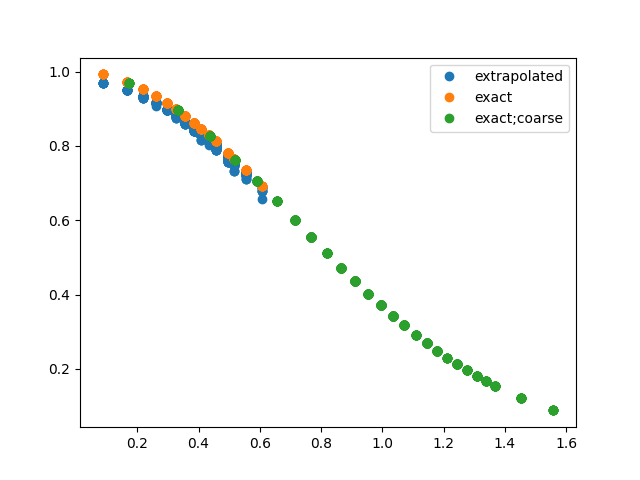

In [201]:
%matplotlib notebook
lBox=2
g=grid([10,10,10],nGhosts=[3,3,3],box=[[-lBox/2,lBox/2],[-lBox/2,lBox/2],[-lBox/2,lBox/2]])
X,Y,Z=g.positions(showGhosts=False)
phi=np.exp(-X**2 - Y**2 - Z**2)
#applyBC(g,phi)
g2=g.refine([[3,6],[3,6],[3,6]],refRatio=2)
X2,Y2,Z2=g2.positions(showGhosts=False)
phi2=np.exp(-X2**2-Y2**2-Z2**2)
r=np.sqrt(X**2 + Y**2 + Z**2)
r2=np.sqrt(X2**2 + Y2**2 + Z2**2)
#plt.plot(r.flatten(),phi.flatten(),"o",label="level 0")
#plt.plot(r2.flatten(),phi2.flatten(),"o",label="level 1")
phi2Interp=interpolate(g,g2,phi)
plt.plot(r2.flatten(),phi2Interp.flatten(),"o",label="extrapolated")
plt.plot(r2.flatten(),phi2.flatten(),"o",label="exact")
plt.plot(r.flatten(),phi.flatten(),"o",label="exact;coarse")
plt.legend()


Compute the second derivative of the gaussian of the coarse, fine and interpolated approximation

<IPython.core.display.Javascript object>


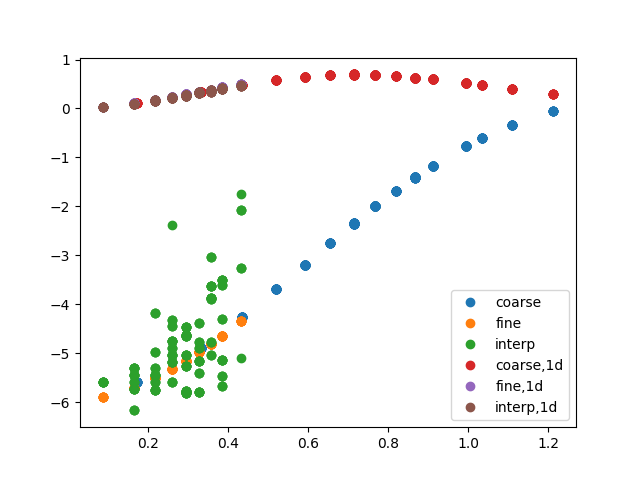

In [202]:
%matplotlib notebook
XSc,lapc=laplacian(g,phi)
XSf,lapf=laplacian(g2,phi2)
rc= np.sqrt(XSc[0]**2 + XSc[1]**2 + XSc[2]**2) 
rf= np.sqrt(XSf[0]**2 + XSf[1]**2 + XSf[2]**2) 
XSI,lapI=laplacian(g2,phi2Interp)
rI=np.sqrt(XSI[0]**2 + XSI[1]**2 + XSI[2]**2)


XSc,grad2c=grad2(g,phi)
XSf,grad2f=grad2(g2,phi2)
XSI,grad2I=grad2(g2,phi2Interp)


plt.plot(rc.flatten(),lapc.flatten(),"o",label="coarse")
plt.plot(rf.flatten(),lapf.flatten(),"o",label="fine")
plt.plot(rI.flatten(),lapI.flatten(),"o",label="interp")

plt.plot(rc.flatten(),grad2c.flatten(),"o",label="coarse,1d")
plt.plot(rf.flatten(),grad2f.flatten(),"o",label="fine,1d")
plt.plot(rI.flatten(),grad2I.flatten(),"o",label="interp,1d")

#plt.plot(np.abs(XSf[0]),lapf,"o",label="fine")
#plt.plot(np.abs(XInterp[0]),lapInterp,"o",label="interp")
plt.legend()
plt.show()

Defines a coarse grid and a a finer grid and initialized data with a gaussian in 1D.<br>
$\phi=e^{-r^2}$<br>

<IPython.core.display.Javascript object>


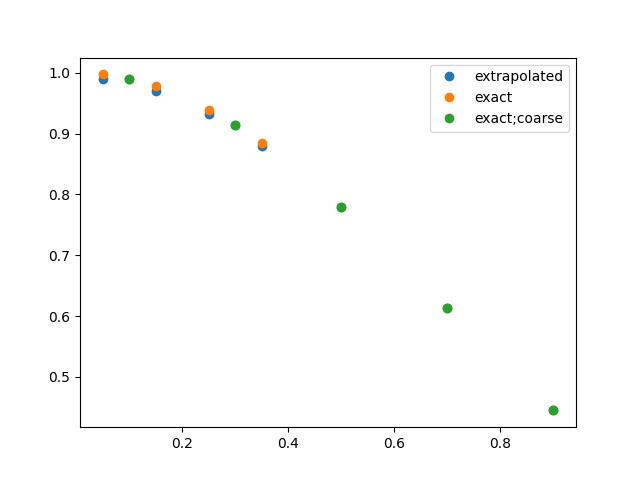

In [203]:
%matplotlib notebook
lBox=2
g=grid([10],nGhosts=[3],box=[[-lBox/2,lBox/2]])
X=g.positions(showGhosts=False)[0]
phi=np.exp(-X**2)
g2=g.refine([[3,4] ],refRatio=2)
X2=g2.positions(showGhosts=False)[0]
phi2=np.exp(-X2**2)
phi2Interp=interpolate(g,g2,phi)
r=np.sqrt(X**2 )
r2=np.sqrt(X2**2 )
plt.plot(r2.flatten(),phi2Interp.flatten(),"o",label="extrapolated")
plt.plot(r2.flatten(),phi2.flatten(),"o",label="exact")
plt.plot(r.flatten(),phi.flatten(),"o",label="exact;coarse")
plt.legend()
#phi2Interp

<IPython.core.display.Javascript object>


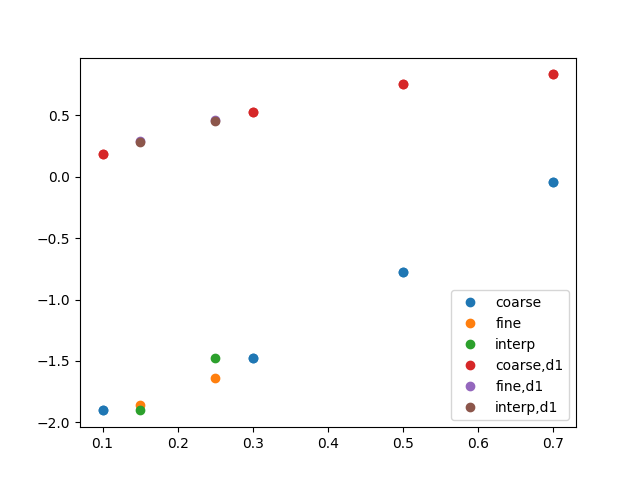

In [204]:
%matplotlib notebook
XSc,lapc=laplacian(g,phi)
XSf,lapf=laplacian(g2,phi2)
XSc,grad2c=grad2(g,phi)
XSf,grad2f=grad2(g2,phi2)
XInterp,grad2Interp=grad2(g2,phi2Interp)
XInterp,lapInterp=laplacian(g2,phi2Interp)
plt.plot(np.abs(XSc[0]),lapc,"o",label="coarse")
plt.plot(np.abs(XSf[0]),lapf,"o",label="fine")
plt.plot(np.abs(XInterp[0]),lapInterp,"o",label="interp")
plt.legend()
plt.show()

plt.plot(np.abs(XSc[0]),grad2c,"o",label="coarse,d1")
plt.plot(np.abs(XSf[0]),grad2f,"o",label="fine,d1")
plt.plot(np.abs(XInterp[0]),grad2Interp,"o",label="interp,d1")
plt.legend()
plt.show()
